In [1]:
import numpy as np
import pandas as pd
import pickle
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina

In [2]:
def Hierarchical_mae(similarity_list,d_list):
    data=pd.DataFrame({'similarity':similarity_list,'d':d_list})
    print(np.mean(data[(data['similarity']>=0.8)]['d']))
    print(np.mean(data[(data['similarity']>=0.7)&(data['similarity']<0.8)]['d']))
    print(np.mean(data[(data['similarity']>=0.6)&(data['similarity']<0.7)]['d']))
    print(np.mean(data[(data['similarity']>=0.5)&(data['similarity']<0.6)]['d']))
    print(np.mean(data[(data['similarity']<0.5)]['d']))
    
    return data[(data['similarity']>=0.5)&(data['similarity']<0.6)]['d'], data[(data['similarity']<0.5)]['d']

In [3]:
train_smiles_list = []
with open('./Dataset/acidic_train_0.70_smiles.txt') as f:
    for line in f.readlines():
        line = line.replace('\n','').split('./t')
        train_smiles_list.append(line[0])

train_ms = [Chem.MolFromSmiles(i) for i in train_smiles_list]
train_fps_list = [AllChem.GetMorganFingerprintAsBitVect(x,2,1024) for x in train_ms]

test_smiles_list = []
with open('./Dataset/acidic_test_0.15_smiles.txt') as f:
    for line in f.readlines():
        line = line.replace('\n','').split('./t')
        test_smiles_list.append(line[0])
        
test_ms = [Chem.MolFromSmiles(i) for i in test_smiles_list]
test_fps_list = [AllChem.GetMorganFingerprintAsBitVect(x,2,1024) for x in test_ms]



In [4]:
similarity_list = []
for test_fps in test_fps_list:
    sims = DataStructs.BulkTanimotoSimilarity(test_fps,train_fps_list)
    similarity_list.append(max(sims))

In [5]:
print(np.sum(np.array(similarity_list) >= 0.8))
print(np.sum(np.array(similarity_list) >= 0.7))
print(np.sum(np.array(similarity_list) >= 0.6))
print(np.sum(np.array(similarity_list) >= 0.5))
print(np.sum(np.array(similarity_list) <0.5))

258
461
789
1101
257


In [6]:
from My_Pka_Model import Pka_basic_view,Pka_acidic_view
import torch
from dgllife.utils import smiles_to_bigraph, CanonicalAtomFeaturizer, CanonicalBondFeaturizer
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

Using backend: pytorch


In [7]:
def predict(smiles,model_view):

    node_featurizer = CanonicalAtomFeaturizer(atom_data_field='h')
    edge_featurizer = CanonicalBondFeaturizer(bond_data_field='h')
    bg = smiles_to_bigraph(smiles= smiles, 
                  node_featurizer=node_featurizer,
                  edge_featurizer=edge_featurizer,canonical_atom_order= False)

    with torch.no_grad():
        model_view.eval()
        molecule_pka,atom_pka = model_view(bg,bg.ndata['h'], bg.edata['h'])
        
    return molecule_pka,atom_pka

In [19]:
acid_pred = Pka_acidic_view(node_feat_size = 74,
                            edge_feat_size = 12,
                            output_size = 1,
                            num_layers= 6,
                            graph_feat_size=200,
                            dropout=0.2)

for i in range(1,2):
    acid_pred.load_state_dict(torch.load('./Trained_model/acidic_ramdom_split_{}.pkl'.format(i),map_location='cuda:1'))

    with open('./Dataset/acidic_test_0.15_smiles.txt') as f: #acidic_test_0.15_smiles.txt,SAMPL7_acidic_smiles.txt
        pred = []
        label = []
        for line in f.readlines():
            line = line.replace('\n','').split('\t')
            molecule_pka,atom_pka = predict(line[0],acid_pred)
            pred.append(molecule_pka)
            label.append(float(line[1]))

    d_list = []
    for i,j in zip(pred,label):
        d_list.append(abs(i-j))
        
    d2_list = []
    for i,j in zip(pred,label):
        d2_list.append(abs(i-j)**2)
    
    print(np.mean(d_list))
    print('')
    
    MAE_in,MAE_out = Hierarchical_mae(similarity_list,d_list)
    print('')


0.5631147899948855

0.3468739285718049
0.421746282833191
0.49756405009756915
0.6533634371805928
0.8659592023114531



In [20]:
len(MAE_in)

312

In [21]:
len(MAE_out)

257

In [30]:
count = 0
for i in MAE_in:
    if i <= 0.6657:
        count += 1
print(count)

222


In [22]:
count = 0
for i in MAE_out:
    if i <= 0.6657:
        count += 1
print(count)

150


In [23]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats, integrate
import seaborn as sns
import matplotlib.pyplot as plt

/home/graphnn/xjc/anaconda/envs/rdkit-env/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


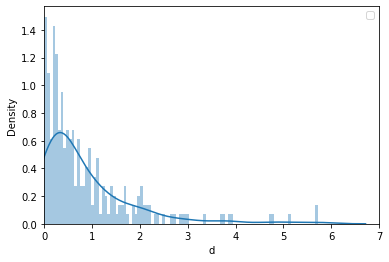

In [28]:
sns.distplot(MAE_out,bins=100)
plt.xlim(0,7)
plt.legend()

/home/graphnn/xjc/anaconda/envs/rdkit-env/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


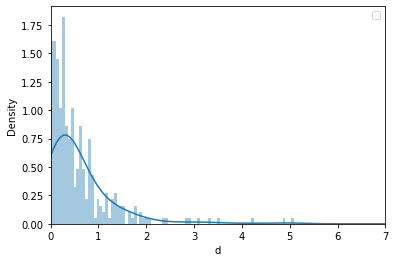

In [29]:
sns.distplot(MAE_in,bins=200)
plt.xlim(0,7)
plt.legend()

In [9]:
for i in range(1,4):
    with open("./Machine_learning_model/acidic_RF_{}.pickle".format(i), 'rb') as fr:
        model = pickle.load(fr)

    df_test = pd.read_csv('./Dataset/acidic_test_0.15_FP.csv',header = None)
    test_data_label = np.array(df_test)
    X_test, y_test = test_data_label[:,1:],test_data_label[:,0]

    y_pred = model.predict(X_test)

    d_list = []
    for i,j in zip(y_pred,y_test):
        d_list.append(abs(i-j))
        
    print(np.mean(d_list))
    print('')
    Hierarchical_mae(similarity_list,d_list)
    print('')

0.7180528008050802

0.2925636257645035
0.5314559909539021
0.6039035226576092
0.8214677816924999
1.3127253640570389

0.7225474531042596

0.2904779811245781
0.5218297765737259
0.6041993417263777
0.8278270227365687
1.3380749508206842

0.7129630746816762

0.28396072313607823
0.5231702231021754
0.5879862893763008
0.8096424021418882
1.3356828839500807



In [10]:
for i in range(1,4):
    with open("./Machine_learning_model/acidic_XGBoost_{}.pickle".format(i), 'rb') as fr:
        model = pickle.load(fr)

    df_test = pd.read_csv('./Dataset/acidic_test_0.15_FP.csv',header = None)
    test_data_label = np.array(df_test)
    X_test, y_test = test_data_label[:,1:],test_data_label[:,0]

    y_pred = model.predict(X_test)

    d_list = []
    for i,j in zip(y_pred,y_test):
        d_list.append(abs(i-j))
        
    print(np.mean(d_list))
    print('')
    
    Hierarchical_mae(similarity_list,d_list)
    print('')

0.6365571816432178

0.2289065585505873
0.5215912022423534
0.5506061217614353
0.7298912962348587
1.1329916503782635

0.6578560298301941

0.2543316479151251
0.5313747752884959
0.5598924835801904
0.7353751621719299
1.1937745476723425

0.646156457563291

0.2475425800530838
0.5373854846925372
0.5599361867366698
0.7408925670275258
1.1272672379861968



In [11]:
for i in range(1,4):
    with open("./Machine_learning_model/acidic_MLP_{}.pickle".format(i), 'rb') as fr:
        model = pickle.load(fr)

    df_test = pd.read_csv('./Dataset/acidic_test_0.15_FP.csv',header = None)
    test_data_label = np.array(df_test)
    X_test, y_test = test_data_label[:,1:],test_data_label[:,0]

    y_pred = model.predict(X_test)

    d_list = []
    for i,j in zip(y_pred,y_test):
        d_list.append(abs(i-j))

    print(np.mean(d_list))
    print('')
    
    Hierarchical_mae(similarity_list,d_list)
    print('')

0.6633813163238147

0.2904769581790385
0.49825574134144607
0.5742133608636963
0.7527205206347005
1.1735100080308019

0.6750120846808126

0.29616887268942593
0.5102106899632636
0.5755421910338963
0.7733287422357983
1.1930959748772065

0.6823699984682632

0.30792844285700616
0.5179559538044113
0.5691390520488684
0.7855477079184272
1.2073905334549422



In [12]:
for i in range(1,4):
    with open("./Machine_learning_model/acidic_SVR_{}.pickle".format(i), 'rb') as fr:
        model = pickle.load(fr)

    df_test = pd.read_csv('./Dataset/acidic_test_0.15_FP.csv',header = None)
    test_data_label = np.array(df_test)
    X_test, y_test = test_data_label[:,1:],test_data_label[:,0]

    y_pred = model.predict(X_test)

    d_list = []
    for i,j in zip(y_pred,y_test):
        d_list.append(abs(i-j))
        
    print(np.mean(d_list))
    print('')

    Hierarchical_mae(similarity_list,d_list)
    print('')

0.7511511713058918

0.27902913605640633
0.5804748878750527
0.6467557997482791
0.8371697134500413
1.3887335345461636

0.7511515556112494

0.27904592069104245
0.5804438844940327
0.6467633331841114
0.8371641847188115
1.3887403016063864

0.751153291072199

0.27903729753191514
0.5804690965287022
0.6467661664900652
0.8371592385348362
1.388740602668775



In [13]:
train_smiles_list = []
with open('./Dataset/basic_train_0.70_smiles.txt') as f:
    for line in f.readlines():
        line = line.replace('\n','').split('./t')
        train_smiles_list.append(line[0])

train_ms = [Chem.MolFromSmiles(i) for i in train_smiles_list]
train_fps_list = [AllChem.GetMorganFingerprintAsBitVect(x,2,1024) for x in train_ms]

test_smiles_list = []
with open('./Dataset/basic_val_0.15_smiles.txt') as f:
    for line in f.readlines():
        line = line.replace('\n','').split('./t')
        test_smiles_list.append(line[0])
        
test_ms = [Chem.MolFromSmiles(i) for i in test_smiles_list]
test_fps_list = [AllChem.GetMorganFingerprintAsBitVect(x,2,1024) for x in test_ms]

In [14]:
similarity_list = []
for test_fps in test_fps_list:
    sims = DataStructs.BulkTanimotoSimilarity(test_fps,train_fps_list)
    similarity_list.append(max(sims))

In [15]:
print(np.sum(np.array(similarity_list) >= 0.8))
print(np.sum(np.array(similarity_list) >= 0.7))
print(np.sum(np.array(similarity_list) >= 0.6))
print(np.sum(np.array(similarity_list) >= 0.5))
print(np.sum(np.array(similarity_list) <0.5))

304
479
743
1027
239


In [16]:
from My_Pka_Model import Pka_basic_view,Pka_acidic_view
import torch
from dgllife.utils import smiles_to_bigraph, CanonicalAtomFeaturizer, CanonicalBondFeaturizer
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

In [17]:
def predict(smiles,model_view):

    node_featurizer = CanonicalAtomFeaturizer(atom_data_field='h')
    edge_featurizer = CanonicalBondFeaturizer(bond_data_field='h')
    bg = smiles_to_bigraph(smiles= smiles, 
                  node_featurizer=node_featurizer,
                  edge_featurizer=edge_featurizer,canonical_atom_order= False)

    with torch.no_grad():
        model_view.eval()
        molecule_pka,atom_pka = model_view(bg,bg.ndata['h'], bg.edata['h'])
        
    return molecule_pka,atom_pka

In [18]:
base_pred = Pka_basic_view(node_feat_size = 74,
                            edge_feat_size = 12,
                            output_size = 1,
                            num_layers= 6,
                            graph_feat_size=200,
                            dropout=0.2)

for i in range(1,4):
    base_pred.load_state_dict(torch.load('./Trained_model/basic_ramdom_split_{}.pkl'.format(i),map_location='cuda:0'))

    with open('./Dataset/basic_test_0.15_smiles.txt') as f: #acidic_test_0.15_smiles.txt,SAMPL7_acidic_smiles.txt
        pred = []
        label = []
        for line in f.readlines():
            line = line.replace('\n','').split('\t')
            molecule_pka,atom_pka = predict(line[0],base_pred)
            pred.append(molecule_pka)
            label.append(float(line[1]))

    d_list = []
    for i,j in zip(pred,label):
        d_list.append(abs(i-j))

    print(np.mean(d_list))
    print('')

    Hierarchical_mae(similarity_list,d_list)
    print('')

0.551367260007717

0.34406493709072306
0.4620872641439655
0.45131961368957835
0.5936404065262635
0.9407016133953486

0.5430566598354795

0.3713807759383715
0.45210317372592834
0.4491557647998977
0.5704056360558506
0.8992451778969874

0.5500978917858643

0.3468240911901913
0.4568688902990428
0.4558379692554264
0.6135643130291405
0.905622856456256



In [19]:
for i in range(1,4):
    with open("./Machine_learning_model/basic_RF_{}.pickle".format(i), 'rb') as fr:
        model = pickle.load(fr)

    df_test = pd.read_csv('./Dataset/basic_test_0.15_FP.csv',header = None)
    test_data_label = np.array(df_test)
    X_test, y_test = test_data_label[:,1:],test_data_label[:,0]

    y_pred = model.predict(X_test)

    d_list = []
    for i,j in zip(y_pred,y_test):
        d_list.append(abs(i-j))
        
    print(np.mean(d_list))
    print('')
        
    Hierarchical_mae(similarity_list,d_list)
    print('')

0.7175995905942668

0.3648043264353553
0.5884399428280607
0.7071024377133166
0.7845758668946006
1.1929246305719712

0.7115287247270602

0.37805896942815903
0.5545882264480962
0.6987047827039368
0.7730574913339625
1.1916573598209057

0.7201391665863911

0.37242512043314246
0.5810276019053178
0.7167324825426059
0.7865225087767754
1.1891604605414774



In [20]:
for i in range(1,4):
    with open("./Machine_learning_model/basic_XGBoost_{}.pickle".format(i), 'rb') as fr:
        model = pickle.load(fr)

    df_test = pd.read_csv('./Dataset/basic_test_0.15_FP.csv',header = None)
    test_data_label = np.array(df_test)
    X_test, y_test = test_data_label[:,1:],test_data_label[:,0]

    y_pred = model.predict(X_test)

    d_list = []
    for i,j in zip(y_pred,y_test):
        d_list.append(abs(i-j))

    print(np.mean(d_list))
    print('')
    
    Hierarchical_mae(similarity_list,d_list)
    print('')

0.6320396966763908

0.3265713968781833
0.4876220803615234
0.6246500152119896
0.6675377488891218
1.0923111404920527

0.6311499665421315

0.32906815033260883
0.5173611946089249
0.5896891489887076
0.698202326336469
1.0648265057409518

0.6325447643858002

0.32128768916803835
0.4929745458286402
0.6175926243021327
0.6775818058810489
1.0936484644324118



In [21]:
for i in range(1,4):
    with open("./Machine_learning_model/basic_MLP_{}.pickle".format(i), 'rb') as fr:
        model = pickle.load(fr)

    df_test = pd.read_csv('./Dataset/basic_test_0.15_FP.csv',header = None)
    test_data_label = np.array(df_test)
    X_test, y_test = test_data_label[:,1:],test_data_label[:,0]

    y_pred = model.predict(X_test)

    d_list = []
    for i,j in zip(y_pred,y_test):
        d_list.append(abs(i-j))

    print(np.mean(d_list))
    print('')
    
    Hierarchical_mae(similarity_list,d_list)
    print('')

0.6257972381640062

0.3662677419455886
0.5532492578929056
0.5848692686956114
0.6392494052901186
1.0382551121124661

0.6239365242836834

0.35659030543803666
0.5319502503798988
0.5732650269859813
0.6628727042459646
1.0410505353278028

0.6322117721213165

0.36503519564222353
0.5465750777068118
0.5887522903839536
0.6553150775968267
1.0553082792167203



In [22]:
for i in range(1,4):
    with open("./Machine_learning_model/basic_SVR_{}.pickle".format(i), 'rb') as fr:
        model = pickle.load(fr)

    df_test = pd.read_csv('./Dataset/basic_test_0.15_FP.csv',header = None)
    test_data_label = np.array(df_test)
    X_test, y_test = test_data_label[:,1:],test_data_label[:,0]

    y_pred = model.predict(X_test)

    d_list = []
    for i,j in zip(y_pred,y_test):
        d_list.append(abs(i-j))

    print(np.mean(d_list))
    print('')

    Hierarchical_mae(similarity_list,d_list)
    print('')

0.6670543761333243

0.350451271443242
0.5344189090047676
0.5966529377171756
0.7229394484955333
1.1782391868625222

0.6670470881924825

0.35043664085851406
0.5344048744460879
0.5966390914817443
0.7229415532558002
1.1782422616184158

0.6670512012801414

0.35044368958329164
0.5344171017581916
0.5966536273379187
0.7229389309342126
1.1782331898624596

